In [1]:
import sys
sys.path.append('/NDDepth/Estimation/nddepth_custom')

In [2]:
import os
import torch
import open3d as o3d
from torchvision import transforms
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from networks.NewCRFDepth import NewCRFDepth
from utils import post_process_depth, flip_lr, compute_errors
from networks.depth_anything_interface import get_model

IMG_PATH = "/scratchdata/processed/indoor_lift/rgb/1850.png"
DEPTH_PATH = "/scratchdata/processed/indoor_lift/depth/1850.png"
MODEL_PATH = "/scratchdata/model-55000-best_d1_0.93399"

DEPTH_ANYTHING_PATH = "/scratchdata/depth_anything_v2_metric_hypersim_vitl.pth"
DEPTH_ANYTHING_ENCODER='vitl'
DEPTH_ANYTHING_MAX_DEPTH=20.0
depth_anything_model = get_model("cpu", DEPTH_ANYTHING_PATH, encoder=DEPTH_ANYTHING_ENCODER, max_depth=DEPTH_ANYTHING_MAX_DEPTH)

ENCODER = "large07"
MAX_DEPTH = 10
EPOCH = 5

torch.manual_seed(42)

model = NewCRFDepth(version=ENCODER, inv_depth=False, max_depth=MAX_DEPTH, pretrained=None, 
                    depth_anything_model=depth_anything_model).to("cuda")
model.train()
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("== Total number of parameters: {}".format(num_params))

num_params_update = sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])
print("== Total number of learning parameters: {}".format(num_params_update))

model = torch.nn.DataParallel(model)
model.cuda()

checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
print("== Loaded checkpoint '{}'".format(MODEL_PATH))
del checkpoint

print("== Model Initialized")
cudnn.benchmark = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.10/dist-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
xFormers not available
xFormers not available
/NDDepth/Estimation/nddepth_custom/networks/depth_anything_interface.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this m

== Load encoder backbone from: None
== Total number of parameters: 683715788
== Total number of learning parameters: 683715788


/tmp/ipykernel_26951/1402240162.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location='cpu')


== Loaded checkpoint '/scratchdata/model-55000-best_d1_0.93399'
== Model Initialized


In [3]:
CAMERA_INFO = "/scratchdata/processed/indoor_lift/camera_info.json"
camera_info = json.load(open(CAMERA_INFO))

image = Image.open(IMG_PATH)

w,h = image.size
target_w = 640
target_h = 480

image = image.resize((target_w, target_h), Image.BILINEAR)
image = np.array(image, dtype=np.float32)
image = image / 255.0

image = torch.from_numpy(image.transpose((2, 0, 1)))
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

#plt.imshow(image.permute(1, 2, 0))

camera_info["K"][0] *= w/target_w
camera_info["K"][2] *= w/target_w
camera_info["K"][4] *= h/target_h
camera_info["K"][5] *= h/target_h

K = np.array([[camera_info["K"][0] / 4.0, 0, camera_info["K"][2] / 4.0, 0],
            [0, camera_info["K"][4] / 4.0, camera_info["K"][5] / 4.0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32) 
inv_K = np.linalg.pinv(K)
inv_K = torch.from_numpy(inv_K)

In [4]:
model.eval()
with torch.no_grad():
    image_torch = torch.Tensor(image.unsqueeze(0).cuda())
    inv_K_torch = torch.Tensor(inv_K.unsqueeze(0).cuda())

    depth1_list, uncer1_list, depth2_list, uncer2_list, normals, distances = model(image_torch, inv_K_torch, EPOCH)
    
    pred_depth = 0.5 * (depth1_list[-1] + depth2_list[-1])
    
    image_flipped = flip_lr(image_torch)
    depth1_list_flipped, uncer1_list_flipped, depth2_list_flipped, uncer2_list_flipped, normals_flipped, distances_flipped = model(image_flipped, inv_K_torch, EPOCH)
    pred_depth_flipped = 0.5 * (depth1_list_flipped[-1] + depth2_list_flipped[-1])
    pred_depth = post_process_depth(pred_depth, pred_depth_flipped)
    normals = (0.5 * (normals + 1)).permute(0, 2, 3, 1)

    pred_depth = pred_depth.cpu().numpy().squeeze()
    pred_normal = normals.cpu().numpy().squeeze()

9.999358


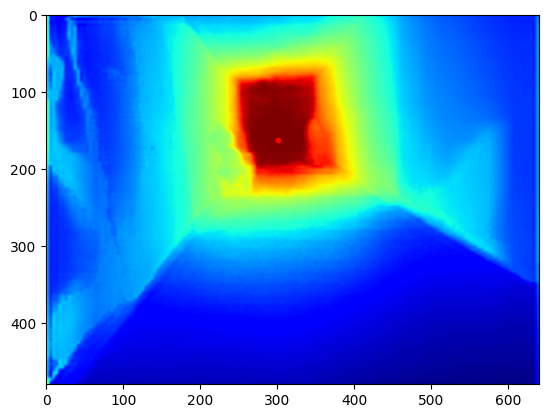

In [5]:
pred_depth = np.reshape(pred_depth, (480, 640))
print(pred_depth.max())
#Find index of max pred_depth
max_index = np.where(pred_depth == pred_depth.max())

plt.imshow(pred_depth, cmap='jet')
plt.scatter(max_index[1], max_index[0], c='r', s=10)

0.0 10.0


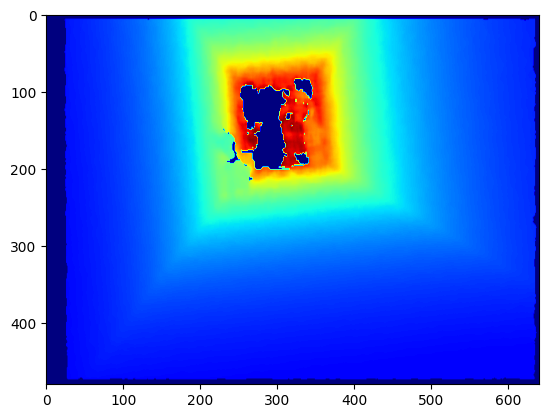

In [6]:
depth = Image.open(DEPTH_PATH)
depth = depth.resize((target_w, target_h), Image.BILINEAR)
depth = np.array(depth, dtype=np.float32) / 1000.0
print(depth.min(), depth.max())
plt.imshow(depth, cmap='jet')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[np.float32(20.828321), np.float32(0.337214), np.float32(0.11669623), np.float32(1.0088412), np.float32(0.44734994), np.float32(0.3328629), np.float64(0.4550887181353139), np.float64(0.8184413861004688), np.float64(0.9683225958348495)]


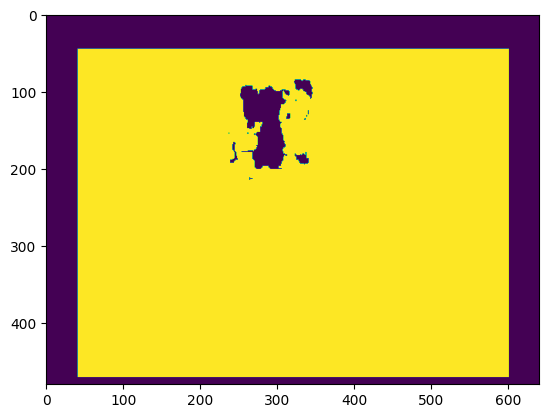

In [7]:
valid_mask = np.logical_and(depth > 1e-3, depth < 10)
eval_mask = np.zeros(valid_mask.shape)
eval_mask[45:471, 41:601] = 1
valid_mask = np.logical_and(valid_mask, eval_mask)
print(valid_mask)
print(compute_errors(depth[valid_mask],pred_depth[valid_mask]))
plt.imshow(valid_mask)

In [8]:
def depth_to_pcd(depth_image, intrinsic, ):
    # Get dimensions of the depth image
    height, width = depth_image.shape

    # Generate a grid of (x, y) coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    depth = depth_image.flatten()

    # Calculate 3D coordinates
    fx, fy, cx, cy = intrinsic[0], intrinsic[5], intrinsic[2], intrinsic[6]
    z = depth

    x_3d = (x - cx) * z / fx
    y_3d = (y - cy) * z / fy

    # Create a point cloud
    points = np.vstack((x_3d, y_3d, z)).T
    return points

In [9]:
camera_K = K[:3,:3].flatten() * 4
coord = depth_to_pcd(pred_depth,camera_K)
color = Image.open(IMG_PATH)
color = color.resize((640, 480), Image.BILINEAR)
color = np.array(color, dtype=np.float64)
color = color.reshape(-1, 3)/255.0

coord = coord[valid_mask.flatten()]
color = color[valid_mask.flatten()]

color = np.delete(color, np.where(coord[:, 2] == 0), axis=0)
coord = np.delete(coord, np.where(coord[:, 2] == 0), axis=0)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coord)
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.visualization.draw_geometries([pcd])